# Определение возраста покупателей

## Исследовательский анализ данных

### Import

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import numpy as np

### Инициализация генератора, загрузка изображений, анализ

Инициализируем генератор

In [ ]:
train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)

Загрузим датафрейм с именами файлов и лейблами

In [ ]:
df = pd.read_csv('/datasets/faces/labels.csv')

Загрузим тренировочную и валидационную выборки

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    df,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(256, 256),
    class_mode='raw',
    subset='training',
    seed=42
)

Found 5694 validated image filenames.


In [ ]:
valid_generator = train_datagen.flow_from_dataframe(
    df,
    directory='/datasets/faces/final_files',
    x_col='file_name',
    y_col='real_age',
    target_size=(256, 256),
    class_mode='raw',
    subset='validation',
    seed=42
)

Found 1897 validated image filenames.


Объем тренировочной выборки - 5694 изображения, валидационной - 1897.

In [ ]:
df.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


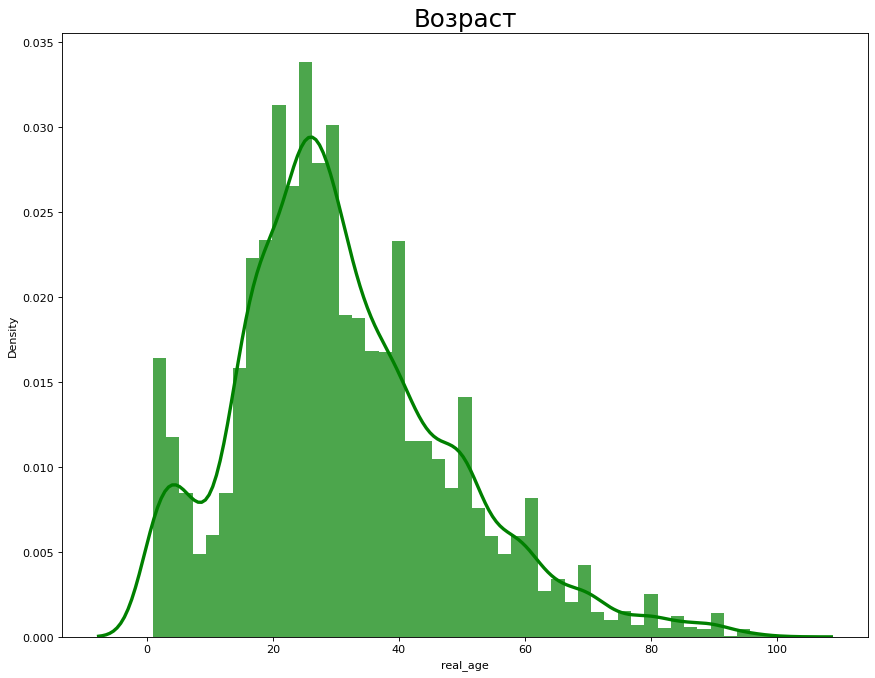

In [ ]:
plt.figure(figsize=(13,10), dpi=80)
sns.distplot(df['real_age'],
             color="g",
             hist_kws={'alpha':.7},
             kde_kws={'linewidth':3})
plt.title('Возраст', fontsize=22)

plt.show()

Наибольший пик по возрасту приходится на промежуток 20-30 лет.

In [ ]:
pic_box = plt.figure(figsize=(100, 100))
for c, i in enumerate(df['file_name'][0:100]):
    image = Image.open(f'/datasets/faces/final_files/{i}')
    pic_box.add_subplot(10,10,c+1)
    plt.imshow(image)
    plt.axis('off')
plt.show()

In [ ]:
features, target = next(train_generator)

features.shape

(32, 256, 256, 3)

Вывод: В результате исследования загружен датасет из  5694 + 1897 изображений и поделен на обучающую и тестовую выборки.Произведена предобработка в виде фиксации подаваемого модели размера (256х256), а так же рескелинг.

Набор изображений в датасете имеет некоторые особенности:

    - некоторое количество из первых ста - черно/белые
    - Около 20% фото повернуты вокруг своей оси
    - Среди первых ста фото попалось одно, на котором не видно лица

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

In [ ]:
import numpy as np
from tensorflow.keras.layers import Conv2D, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras import regularizers
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from tensorflow.keras.metrics import MeanAbsoluteError

In [ ]:
### Функция загрузки обучающего набора данных
### На вход принимает информацию о расположении csv файла, содержащего имена файлов-изображений.
### На выходе выдает сформированный генератор изображений

def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                        rescale=1./255)
    df = pd.read_csv(f'{path}/labels.csv')
    train_datagen_flow = train_datagen.flow_from_dataframe(
        df,
        directory='/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=64,
        class_mode='raw',
        subset='training',
        seed=42
    )
    return train_datagen_flow

In [ ]:
### Функция загрузки тестового набора данных
### Принцип работы аналогичен предыдущей функции

def load_test(path):
    train_datagen = ImageDataGenerator(validation_split=0.25,
                                        rescale=1./255)
    df = pd.read_csv(f'{path}/labels.csv')

    trest_datagen_flow = train_datagen.flow_from_dataframe(
        df,
        directory='/datasets/faces/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(256, 256),
        batch_size=64,
        class_mode='raw',
        subset='validation',
        seed=42
    )
    return trest_datagen_flow

In [ ]:
### Функция построения нейронной сети
### На вход принимает информацию о размере данных на первом слое
### На выходе выдает сконструированную модель для обучения

def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=(256, 256, 3),
                    weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                    include_top=False)


    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(6, activation='relu'))
    model.add(Dense(1, activation='relu'))


    model.compile(loss='mean_squared_error',
                  optimizer='adam', metrics=['mean_absolute_error'])

    return model

In [ ]:
### Функция обучения нейронной сети
### На вход принимает перменную модели, обучающую и тестовую выборки, информацию о размере батча,
### кол-во эпох, кол-во шагов в эпоху, кол-во шагов на валидации эпохи
### На выходе выдает обученную модель

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    train_datagen_flow = train_data
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size,
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

Результат работы модели представлен ниже.

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.


Train for 89 steps, validate for 30 steps
Epoch 1/20
89/89 - 62s - loss: 239.2986 - mean_absolute_error: 11.6162 - val_loss: 769.2472 - val_mean_absolute_error: 22.8372
Epoch 2/20
89/89 - 49s - loss: 127.4033 - mean_absolute_error: 8.6247 - val_loss: 362.9128 - val_mean_absolute_error: 14.2119
Epoch 3/20
89/89 - 49s - loss: 98.4550 - mean_absolute_error: 7.5960 - val_loss: 356.5036 - val_mean_absolute_error: 14.0747
Epoch 4/20
89/89 - 47s - loss: 68.4646 - mean_absolute_error: 6.3343 - val_loss: 412.0904 - val_mean_absolute_error: 15.2917
Epoch 5/20
89/89 - 49s - loss: 48.2488 - mean_absolute_error: 5.3221 - val_loss: 419.1695 - val_mean_absolute_error: 15.4521
Epoch 6/20
89/89 - 50s - loss: 33.1330 - mean_absolute_error: 4.4465 - val_loss: 392.1498 - val_mean_absolute_error: 14.7944
Epoch 7/20
89/89 - 46s - loss: 25.8372 - mean_absolute_error: 3.9480 - val_loss: 491.9640 - val_mean_absolute_error: 17.0846
Epoch 8/20
89/89 - 45s - loss: 19.5081 - mean_absolute_error: 3.4093 - val_loss: 220.0368 - val_mean_absolute_error: 11.2609
Epoch 9/20
89/89 - 45s - loss: 16.0073 - mean_absolute_error: 3.0704 - val_loss: 183.8507 - val_mean_absolute_error: 10.2216
Epoch 10/20
89/89 - 44s - loss: 11.5355 - mean_absolute_error: 2.6275 - val_loss: 129.2826 - val_mean_absolute_error: 8.4214
Epoch 11/20
89/89 - 45s - loss: 9.0720 - mean_absolute_error: 2.3251 - val_loss: 124.4829 - val_mean_absolute_error: 8.4643
Epoch 12/20
89/89 - 45s - loss: 7.3971 - mean_absolute_error: 2.1044 - val_loss: 82.3889 - val_mean_absolute_error: 6.8478
Epoch 13/20
89/89 - 45s - loss: 6.8225 - mean_absolute_error: 1.9887 - val_loss: 77.5292 - val_mean_absolute_error: 6.6174
Epoch 14/20
89/89 - 46s - loss: 5.8596 - mean_absolute_error: 1.8728 - val_loss: 84.4056 - val_mean_absolute_error: 7.1380
Epoch 15/20
89/89 - 46s - loss: 5.2053 - mean_absolute_error: 1.7453 - val_loss: 81.6229 - val_mean_absolute_error: 6.7581
Epoch 16/20
89/89 - 44s - loss: 4.9481 - mean_absolute_error: 1.6934 - val_loss: 80.2000 - val_mean_absolute_error: 6.6799
Epoch 17/20
89/89 - 46s - loss: 5.2503 - mean_absolute_error: 1.7636 - val_loss: 76.6864 - val_mean_absolute_error: 6.6314
Epoch 18/20
89/89 - 58s - loss: 4.8774 - mean_absolute_error: 1.6841 - val_loss: 86.5055 - val_mean_absolute_error: 7.1592
Epoch 19/20
89/89 - 56s - loss: 4.9797 - mean_absolute_error: 1.6944 - val_loss: 85.7101 - val_mean_absolute_error: 6.8709
Epoch 20/20
89/89 - 57s - loss: 5.4096 - mean_absolute_error: 1.7646 - val_loss: 75.9979 - val_mean_absolute_error: 6.6435

30/30 - 12s - loss: 75.9979 - mean_absolute_error: 6.6435
Test MAE: 6.6435

```

## Анализ обученной модели

Для решения задачи была выбрана CNN с архитектурой ResNet50. После свертывания 1 слой для пулинга и 1 полносвязный слой с 8 нейронами. В результате значение заявленной условием задачи метрики MAE составило 6,68, что соотвествует пределу в 8.  

Если рассуждать о применимости модели, то считаю, что дальнейшим шагом необходимо обсудить варианты с заказчиком. 6,6 лет - это ощутимая разница, ведь модель может посчитать 23-хлетнего клиента несовершеннолетним, и, в случае, если использовать модель для контроля работников торгового зала - неверно расценить их (работников) действия. Стоит отметить, что даже в реальной жизни визуальная разница между молодыми людьми 17 лет и 23 лет не велика, поэтому кассиры обычно наделены правом просить предьявить документы. Так вот модель можно использовать, например, для сигнала работнику торгового зала запросить документы у посетителя. В таком случае я бы решил эту задачу по другому - переформулировал бы ее в задачу классификации на определение "критического" и "не критического возраста".
Если говорить о рекомендациях клиентам - можно тоже решить задачу по другому - например, разбить возрастной показатель на группы, ведь сомнительно, что, допустим, у клиентов в возврасте 60 лет будут разительно иные предпочтения, чем у 65-тилетнего. В случаях рекомендаций, помимо возраста неплохо было бы учесть и другую информацию - например пол клиента или время посещения магазина (утро-вечер) и т.п.